In [1]:
from all_functions import * 
from sklearn.decomposition import PCA
import copy
from scipy.linalg import eigh
from sklearn.linear_model import LinearRegression

In [2]:
"""
This new functions takes the following inputs: 

    name -- the name of the Y variables, should be within double quote
    ncomps -- number of principal components to be used 
    error_comps -- number of error components to be used 
    outlier_remove -- a logical variable indicating whether to remove outliers 
    
This function select the Y variable based on the input name, and set X as 
all other variables. 

"""
def FRED_MD_DATA_PREP(name, ncomps = 5, error_comps = 5, outlier_remove = False):
   
    """
    Read the entire data
    """
    
    data = pd.read_csv('Transformed_na_removed.csv')
    
    """
    Set the Y axis to be the column of given name in the input, 
    remove that column and set the rest of the matrix as X. 
    Finally, do PCA on the X matrix. 
    
    """
    
    Y_axis = name
    X = copy.deepcopy(data)
    X.pop(name)
    X = X.to_numpy()
    n_data = X.shape[0]
    Y = data[name].to_numpy()
    W, V = eigh(X @ X.T)
    F_hat = np.sqrt(n_data) * V[:,-ncomps:] # select last ncomps columns of V
    B_hat = (1/n_data) * (X.T @ F_hat)
    
    if error_comps > 0:
        
        """
        First we project out the space of principal components
        to estimate the idiosyncratic errors. 
        """
        
#         loadings = X.T @ X_pca @ np.linalg.inv(X_pca.T @ X_pca) # OLS of X on X.pca
#         errors = X - X_pca @ loadings.T # OLS residuals
        U_hat = X - (F_hat @ B_hat.T)
        model = LinearRegression()
        model.fit(F_hat, Y)
        Y_u = Y - model.predict(F_hat)
        
        
        """
            Next we apply conditional SURE independent screening to select the 
            idiosyncratic components.
        """
       
        def cor_cal(x):
            return np.corrcoef(x, Y_u)[0, 1]
        
        cor_vec = np.apply_along_axis(cor_cal, 0, U_hat)
        idx = np.argsort(-np.abs(cor_vec))
        errors_to_add = U_hat[:,idx[:error_comps]]
        Data = np.hstack([F_hat, errors_to_add, Y.reshape(-1, 1)])
    
    else:
        Data = np.hstack([F_hat, Y.reshape(-1, 1)])
    
    if outlier_remove:
        Q1 = np.percentile(Y, 25, method = 'midpoint')
        Q3 = np.percentile(Y, 75, method = 'midpoint')
        IQR = Q3 - Q1
        upper=Q3+1.5*IQR
        upper_array=np.array(Y<=upper)
        lower=Q1-1.5*IQR
        lower_array=np.array(Y>=lower)
        index_keep = upper_array & lower_array
        Data = Data[index_keep[:,0].tolist(),:]
        print("The number of data being removed is ", Y.shape[0]-Data.shape[0])
        
    return Data, Y_axis

In [3]:
def UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True):
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])
    X_pre = train_data[:,:-1]
    Y_pre = train_data[:,-1].reshape(-1,1)
    X_opt = train_data[:,:-1]
    Y_opt = train_data[:,-1].reshape(-1,1)
    X_adj = train_data[:,:-1]
    Y_adj = train_data[:,-1].reshape(-1,1)
    X_t = test_data[:,:-1]
    Y_t = test_data[:,-1].reshape(-1,1)


    n_pre = len(Y_pre)
    n_opt = len(Y_opt)
    n_adj = len(Y_adj)
    n_t = len(Y_t)

    # Obtain mean estimator
    known_mean = "False"
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN1"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)

    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre,X_opt,X_adj,X_t,est_type ="NN1")


    # Obtain quantile estimators
    quantile = [0.05,0.35,0.65,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
    E_t = E_t.T


    # solve optimization problem

    optimal_weight, V100_adj, V100_t= solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 2)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

    # adjust interval
    if shrink: 
        alpha = 0.05
        delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha,stepsize = 0.001)

        # plot
        V_alpha_t = delta*V100_t
    else:
        V_alpha_t = V100_t
    
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    print("The overall coverage for UTOPIA is", coverage)
    print("Mean bandwidth on test data for UTOPIA is", bandwidth)
    return X_t,Y_t,M_t,V_alpha_t,coverage,bandwidth

In [4]:
def LQR_FRED_MD_MULTIVARIATE(Data):
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])

    X_lin = train_data[:,:-1]
    Y_lin = train_data[:,-1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_quantile = train_data[:,:-1]
    Y_quantile = train_data[:,-1].reshape(-1,1)
    X_test = test_data[:,:-1]
    Y_test = test_data[:,-1].reshape(-1,1)

    # Estimate the mean using NN1
    est_type = "NN1"
    M_quantile, M_test = mean_est_others(est_type,X_lin,Y_lin,X_quantile,X_test)

    # Estimate the quantile
    alpha = 0.05

    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0, solver = 'highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)


    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    print("The overall coverage for LQR is", coverage)
    print("Mean bandwidth on test data for LQR is", bandwidth)
    return X_test,Y_test,M_test,V_test, coverage, bandwidth

In [5]:
def SplitCF_FRED_MD_MULTIVARIATE(Data): 
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])


    X_lin = train_data[:,:-1]
    Y_lin = train_data[:,1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_res = train_data[:,:-1]
    Y_res = train_data[:,1].reshape(-1,1)
    y_res = Y_res[:,0]
    X_test = test_data[:,:-1]
    Y_test = test_data[:,1].reshape(-1,1)
    y_test = Y_test[:,0]

    # Estimate the mean using NN1
    est_type = "NN1"
    Y_res_pred, M_test = mean_est_others(est_type,X_lin,Y_lin,X_res,X_test)
    y_res_pred = Y_res_pred[:,0]

    # Calculate the conformity scores
    residuals = np.abs(y_res - y_res_pred)

    alpha = 0.05  # 95% confidence level
    k = int((1 - alpha) * len(y_lin))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    # Calculate the prediction interval
    v_test = (threshold**2)*np.ones(len(y_test))
    V_test = v_test.reshape(-1,1)
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    print("The overall coverage for SplitCF is", coverage)
    print("Mean bandwidth on test data for SplitCF is", bandwidth)
    return X_test,Y_test,M_test,V_test,coverage,bandwidth

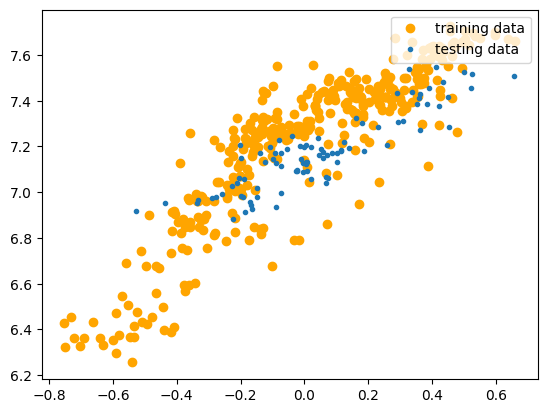

In [14]:
Data, Y_axis = FRED_MD_DATA_PREP('PERMIT')
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])
plt.plot(train_data[:,8],train_data[:,-1],'o',color = 'orange',label = 'training data')
plt.plot(test_data[:,8],test_data[:,-1],'.', label = 'testing data')
plt.legend(loc="upper right")
plt.show()

In [15]:
data = pd.read_csv('Transformed_na_removed.csv')
col = data.columns

In [16]:
output_coverage = np.zeros((len(data.columns)-1, 3))
output_bandwidth = np.zeros((len(data.columns)-1, 3))

for j in range(1, len(data.columns)):
    idx = data.columns[j]
    Data, Y_axis = FRED_MD_DATA_PREP(idx, ncomps=2, error_comps=4)
    
    X_t,Y_t,M_t,V_alpha_t, coverage_utopia, bandwidth_utopia = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
    X_test,Y_test,M_test,V_test,coverage_lqr, bandwidth_lqr = LQR_FRED_MD_MULTIVARIATE(Data)
    X_test,Y_test,M_test,V_test, coverage_split, bandwidth_split = SplitCF_FRED_MD_MULTIVARIATE(Data)
    
    output_coverage[j-1,] = np.array([coverage_utopia, coverage_lqr, coverage_split]).reshape(-1)
    output_bandwidth[j-1,] = np.array([bandwidth_utopia, bandwidth_lqr, bandwidth_split]).reshape(-1)
    print(j, "th index is done!")

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.9120879120879121
Mean bandwidth on test data for UTOPIA is 0.00039518730148926397
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.00012302400467453187
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0006362940351433906
1 th index is done!
The overall coverage for UTOPIA is 0.8131868131868132
Mean bandwidth on test data for UTOPIA is 0.00015963007673833508
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.0001665374981045839
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0006489985163214247
2 th index is done!
The overall coverage for UTOPIA is 0.7362637362637363
Mean bandwidth on test data for UTOPIA is 0.00022425691650741297
The overall coverage for LQR is 0.6813186813186813
Mean bandwidth on test data for LQR is 0.00014872557453694425
The overall coverage for 

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.6483516483516484
Mean bandwidth on test data for UTOPIA is 0.00013715400107748506
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.00013149306459816907
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0006286616236834696
7 th index is done!
The overall coverage for UTOPIA is 0.6703296703296703
Mean bandwidth on test data for UTOPIA is 0.00013475392779411705
The overall coverage for LQR is 0.7252747252747253
Mean bandwidth on test data for LQR is 0.00018977364206870646
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0006058775239766817
8 th index is done!
The overall coverage for UTOPIA is 0.7582417582417582
Mean bandwidth on test data for UTOPIA is 0.0001507259138335623
The overall coverage for LQR is 0.6813186813186813
Mean bandwidth on test data for LQR is 0.00014569565267481515
The overall coverage for 

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8351648351648352
Mean bandwidth on test data for UTOPIA is 0.0002728359793349336
The overall coverage for LQR is 0.8791208791208791
Mean bandwidth on test data for LQR is 0.0004863946326232475
The overall coverage for SplitCF is 0.6373626373626373
Mean bandwidth on test data for SplitCF is 0.0019237876642171539
15 th index is done!
The overall coverage for UTOPIA is 0.6923076923076923
Mean bandwidth on test data for UTOPIA is 0.00019465253763809005
The overall coverage for LQR is 0.7582417582417582
Mean bandwidth on test data for LQR is 0.0002245014520724141
The overall coverage for SplitCF is 0.6043956043956044
Mean bandwidth on test data for SplitCF is 0.0007903542517566593
16 th index is done!
The overall coverage for UTOPIA is 0.6593406593406593
Mean bandwidth on test data for UTOPIA is 0.0021894912041145126
The overall coverage for LQR is 0.9560439560439561
Mean bandwidth on test data for LQR is 0.007451933339918664
The overall coverage for Spl

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7582417582417582
Mean bandwidth on test data for UTOPIA is 0.0001453149409699757
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.00010978308325675559
The overall coverage for SplitCF is 0.6813186813186813
Mean bandwidth on test data for SplitCF is 0.0004280132684858597
23 th index is done!
The overall coverage for UTOPIA is 0.9120879120879121
Mean bandwidth on test data for UTOPIA is 0.07793448702328393
The overall coverage for LQR is 0.7032967032967034
Mean bandwidth on test data for LQR is 0.022118243351221978
The overall coverage for SplitCF is 0.7912087912087912
Mean bandwidth on test data for SplitCF is 0.000613733240982745
24 th index is done!
The overall coverage for UTOPIA is 0.7362637362637363
Mean bandwidth on test data for UTOPIA is 1.2860112947216993
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.9369267635853153
The overall coverage for SplitCF is 0

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7802197802197802
Mean bandwidth on test data for UTOPIA is 0.0001594842412161124
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00013342488281912424
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0005997818309882033
32 th index is done!


/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.6593406593406593
Mean bandwidth on test data for UTOPIA is 0.00015104820027841173
The overall coverage for LQR is 0.7582417582417582
Mean bandwidth on test data for LQR is 0.00023343937080940092
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0006486414708722634
33 th index is done!


/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7252747252747253
Mean bandwidth on test data for UTOPIA is 0.00042592611730821655
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.0002771687162109762
The overall coverage for SplitCF is 0.7472527472527473
Mean bandwidth on test data for SplitCF is 0.0005997117632051141
34 th index is done!
The overall coverage for UTOPIA is 0.7032967032967034
Mean bandwidth on test data for UTOPIA is 0.0001904612538515055
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00018248003066756379
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0006134344543179967
35 th index is done!
The overall coverage for UTOPIA is 0.7692307692307693
Mean bandwidth on test data for UTOPIA is 0.00015579710847923604
The overall coverage for LQR is 0.7032967032967034
Mean bandwidth on test data for LQR is 0.00019805349517045836
The overall coverage for

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.9120879120879121
Mean bandwidth on test data for UTOPIA is 0.00016885551552471724
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00015646341865102468
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0005990456932603877
37 th index is done!


/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8131868131868132
Mean bandwidth on test data for UTOPIA is 0.00023893185194698578
The overall coverage for LQR is 0.7362637362637363
Mean bandwidth on test data for LQR is 0.0002938679391468846
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0005944504150923293
38 th index is done!


/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8021978021978022
Mean bandwidth on test data for UTOPIA is 0.00016573504541559704
The overall coverage for LQR is 0.6373626373626373
Mean bandwidth on test data for LQR is 0.00014824803688615198
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.000622434069544078
39 th index is done!


/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.9010989010989011
Mean bandwidth on test data for UTOPIA is 0.00023627244342018134
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0001431354381736701
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0006136742454223159
40 th index is done!
The overall coverage for UTOPIA is 0.9120879120879121
Mean bandwidth on test data for UTOPIA is 0.00017589795549745137
The overall coverage for LQR is 0.7142857142857143
Mean bandwidth on test data for LQR is 0.000203140514623002
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0005804918672990637
41 th index is done!
The overall coverage for UTOPIA is 0.7142857142857143
Mean bandwidth on test data for UTOPIA is 0.00014929912895489305
The overall coverage for LQR is 0.6593406593406593
Mean bandwidth on test data for LQR is 0.0001500833571938754
The overall coverage for S

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7802197802197802
Mean bandwidth on test data for UTOPIA is 0.00021852706683762015
The overall coverage for LQR is 0.7582417582417582
Mean bandwidth on test data for LQR is 0.0003018695361019408
The overall coverage for SplitCF is 0.8131868131868132
Mean bandwidth on test data for SplitCF is 0.0006070727294660452
61 th index is done!
The overall coverage for UTOPIA is 0.8461538461538461
Mean bandwidth on test data for UTOPIA is 0.0005873825000163322
The overall coverage for LQR is 0.8241758241758241
Mean bandwidth on test data for LQR is 0.0004481276851471298
The overall coverage for SplitCF is 0.4945054945054945
Mean bandwidth on test data for SplitCF is 0.0016934189791621831
62 th index is done!
The overall coverage for UTOPIA is 0.7032967032967034
Mean bandwidth on test data for UTOPIA is 0.0004343378963986681
The overall coverage for LQR is 0.8791208791208791
Mean bandwidth on test data for LQR is 0.0006816001131124672
The overall coverage for Sp

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8021978021978022
Mean bandwidth on test data for UTOPIA is 0.00014653442112620203
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00011697946426125709
The overall coverage for SplitCF is 0.7582417582417582
Mean bandwidth on test data for SplitCF is 0.000629639006408035
72 th index is done!
The overall coverage for UTOPIA is 0.6923076923076923
Mean bandwidth on test data for UTOPIA is 0.001195998708744333
The overall coverage for LQR is 0.8791208791208791
Mean bandwidth on test data for LQR is 0.0020069476617963454
The overall coverage for SplitCF is 0.5054945054945055
Mean bandwidth on test data for SplitCF is 0.0043898554785333005
73 th index is done!
The overall coverage for UTOPIA is 0.7912087912087912
Mean bandwidth on test data for UTOPIA is 0.000743653611311115
The overall coverage for LQR is 0.8241758241758241
Mean bandwidth on test data for LQR is 0.0014042728427191597
The overall coverage for Spli

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7362637362637363
Mean bandwidth on test data for UTOPIA is 0.00022538761935241014
The overall coverage for LQR is 0.6593406593406593
Mean bandwidth on test data for LQR is 0.00023849548895795968
The overall coverage for SplitCF is 0.7912087912087912
Mean bandwidth on test data for SplitCF is 0.0006890524090612589
94 th index is done!
The overall coverage for UTOPIA is 0.8021978021978022
Mean bandwidth on test data for UTOPIA is 0.0006425940476891699
The overall coverage for LQR is 0.8681318681318682
Mean bandwidth on test data for LQR is 0.0008172472315918556
The overall coverage for SplitCF is 0.23076923076923078
Mean bandwidth on test data for SplitCF is 0.0008519803803310312
95 th index is done!
The overall coverage for UTOPIA is 0.9230769230769231
Mean bandwidth on test data for UTOPIA is 0.0010946343566574643
The overall coverage for LQR is 0.9560439560439561
Mean bandwidth on test data for LQR is 0.0022688822937848825
The overall coverage for 

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8131868131868132
Mean bandwidth on test data for UTOPIA is 0.00015306884053768927
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.00012307568809224336
The overall coverage for SplitCF is 0.7472527472527473
Mean bandwidth on test data for SplitCF is 0.0005821287739174408
100 th index is done!
The overall coverage for UTOPIA is 0.8131868131868132
Mean bandwidth on test data for UTOPIA is 0.0002134454015644173
The overall coverage for LQR is 0.7582417582417582
Mean bandwidth on test data for LQR is 0.0002831560632429996
The overall coverage for SplitCF is 0.7362637362637363
Mean bandwidth on test data for SplitCF is 0.0005844717402775446
101 th index is done!
The overall coverage for UTOPIA is 0.8351648351648352
Mean bandwidth on test data for UTOPIA is 0.007014415306606764
The overall coverage for LQR is 0.978021978021978
Mean bandwidth on test data for LQR is 0.012650783121235716
The overall coverage for Sp

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.5714285714285714
Mean bandwidth on test data for UTOPIA is 0.0001397741508004785
The overall coverage for LQR is 0.6923076923076923
Mean bandwidth on test data for LQR is 0.00017560209723521618
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0005923871320834076
105 th index is done!
The overall coverage for UTOPIA is 0.6373626373626373
Mean bandwidth on test data for UTOPIA is 0.00020510771404391286
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.00030833408112429576
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0006076123816067296
106 th index is done!
The overall coverage for UTOPIA is 0.7692307692307693
Mean bandwidth on test data for UTOPIA is 0.00024796660310804616
The overall coverage for LQR is 0.6923076923076923
Mean bandwidth on test data for LQR is 0.00021824174161737744
The overall coverage 

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7252747252747253
Mean bandwidth on test data for UTOPIA is 0.00021560886078123028
The overall coverage for LQR is 0.6043956043956044
Mean bandwidth on test data for LQR is 0.0001720794426970037
The overall coverage for SplitCF is 0.7912087912087912
Mean bandwidth on test data for SplitCF is 0.0006412559075858343
108 th index is done!
The overall coverage for UTOPIA is 0.6373626373626373
Mean bandwidth on test data for UTOPIA is 0.00014002019962023116
The overall coverage for LQR is 0.6373626373626373
Mean bandwidth on test data for LQR is 0.0001696141334457267
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0006012870979996335
109 th index is done!
The overall coverage for UTOPIA is 0.7362637362637363
Mean bandwidth on test data for UTOPIA is 0.0001806969414824375
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.00014077185180778925
The overall coverage fo

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.9230769230769231
Mean bandwidth on test data for UTOPIA is 0.00018423003356568473
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00014467453834540834
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0006034255511589944
118 th index is done!
The overall coverage for UTOPIA is 0.7582417582417582
Mean bandwidth on test data for UTOPIA is 0.00020237222589902668
The overall coverage for LQR is 0.6923076923076923
Mean bandwidth on test data for LQR is 0.00018989755672641764
The overall coverage for SplitCF is 0.31868131868131866
Mean bandwidth on test data for SplitCF is 0.0006071957820137835
119 th index is done!
The overall coverage for UTOPIA is 0.7362637362637363
Mean bandwidth on test data for UTOPIA is 0.0002503965593751648
The overall coverage for LQR is 0.7362637362637363
Mean bandwidth on test data for LQR is 0.00025590603958962116
The overall coverage

/home/jg5300/.conda/envs/torch-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8461538461538461
Mean bandwidth on test data for UTOPIA is 0.0002351974068359921
The overall coverage for LQR is 0.7142857142857143
Mean bandwidth on test data for LQR is 0.0001962289127641343
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0005706711399046955
121 th index is done!
The overall coverage for UTOPIA is 0.8681318681318682
Mean bandwidth on test data for UTOPIA is 29.440451943763893
The overall coverage for LQR is 0.9560439560439561
Mean bandwidth on test data for LQR is 63.22269311058218
The overall coverage for SplitCF is 0.6153846153846154
Mean bandwidth on test data for SplitCF is 0.002431765476489749
122 th index is done!
The overall coverage for UTOPIA is 0.8791208791208791
Mean bandwidth on test data for UTOPIA is 0.0004216502785370757
The overall coverage for LQR is 1.0
Mean bandwidth on test data for LQR is 0.002790593642045699
The overall coverage for SplitCF is 0.802197802197

In [17]:
idx = np.where(output_coverage[:,0] > 0.945)[0]
print(data.columns[idx+1])
print(output_coverage[idx,:])
print(output_bandwidth[idx,:])

Index(['HOUST', 'HOUSTNE', 'PERMIT', 'PERMITNE', 'PERMITS', 'TOTRESNS',
       'NONBORRES', 'REALLN', 'S.P.div.yield', 'S.P.PE.ratio', 'FEDFUNDS',
       'TB3MS', 'TB3SMFFM', 'T10YFFM'],
      dtype='object')
[[0.94505495 0.         0.78021978]
 [0.96703297 0.07692308 0.76923077]
 [0.96703297 0.         0.78021978]
 [0.96703297 0.03296703 0.76923077]
 [0.96703297 0.         0.78021978]
 [0.98901099 0.98901099 0.78021978]
 [1.         0.71428571 0.69230769]
 [0.98901099 0.74725275 0.78021978]
 [1.         0.83516484 0.46153846]
 [1.         0.96703297 0.61538462]
 [0.98901099 0.47252747 0.26373626]
 [0.95604396 0.78021978 0.2967033 ]
 [0.94505495 0.23076923 0.56043956]
 [1.         0.48351648 0.07692308]]
[[8.77601112e+00 3.07012276e+00 6.31321913e-04]
 [4.87753595e+00 1.63845744e+00 7.07122604e-04]
 [9.37971097e+00 2.58365162e+00 6.31391444e-04]
 [4.90060509e+00 1.61203804e+00 7.11621305e-04]
 [6.53690519e+00 1.94255742e+00 6.97838122e-04]
 [1.63346452e-03 5.74247719e-03 6.19108936e-04